#Pair-wise transfer learning

This exercise demonstrates a transfer learning approach using the ALIGNN architecture. We will first pre-train an ALIGNN model on a dataset of formation energies. Subsequently, we will employ this pre-trained model as the initialization point for training a second ALIGNN model tasked with predicting the highest optical phonon mode frequency. This fine-tuning strategy will involve updating all model parameters during the training phase for the phonon mode frequency prediction task. We will then compare the predictive performance of this fine-tuned model against that of a baseline ALIGNN model, which we shall refer to as the "SCRATCH" model, trained exclusively on the phonon mode frequency data. This comparison will highlight the potential benefits of leveraging pre-training for downstream property prediction. This specific fine-tuning methodology, where all layers are retrained, is one of several possible strategies detailed in the relevant literature on transfer learning and is chosen here for illustrative purposes.

# Installation
Install and initialize condacolab, a library that allows you to use the Conda package manager within a Google Colab environment


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [ ]:
# import condacolab
# condacolab.check()

✨🍰✨ Everything looks OK!


Install ALIGNN  (It might take ~ 6-8 minutes)

In [ ]:
%%time
!conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - dgl=2.1.0
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_1         105 KB  conda-forge
    alignn-2024.10.30          |     pyhd8ed1ab_0          76 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_1          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_2          18 KB  conda-forge
    babel-2.16.0               |     pyhd8ed1ab_1         6.2 MB  conda-forge
    blinker-1.9.0       

# Loading and pre-processing the data


It is always better to standardize and normalize the feature and target values before any ML exercise. The following methodology can be used in the same order for any kind of raw data that is available on any materials data repository.

In the following exercise we will take up the formation energy (in eV/atom) and highest optical mode phonon frequency (in $cm^{-1}$) datasets from the MatBench repository.

1.   We split the raw data into train and test dataset in the ratio 90:10
2.   We standardize the target values of both train and test set using the StandardScaler class from sklearn (ref: https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html) using only the training data statistics
     
     **z = (x - u) / s**

          z => Standard score
          x => Sample
          u => Mean
          s => Standard deviation
3.   We then normalize the values between -1 and +1

     **x$_{norm}$ = a + (((x - x$_{minimum}$) * (b - a)) / range of x)**
     
          a, b => Customized range to normalize (say -1 to +1)
4.   We choose 200 random points from the training dataset for illustration


**Make sure to use the training data statistics for standardizing and normalizing both the train and the test set**

## Download the data

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1LupaRopHz5v0yEyoxzn0j2CWbwCZVrr_?usp=sharing
!gdown --folder https://drive.google.com/drive/folders/1PO7eyZHc8WOHsuYUlYB1Cj1OSR-wJrZA?usp=sharing

Retrieving folder contents
Processing file 1iXEihej_LQgTLPqOk66oPV3o01Ze7SBp current_model.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1iXEihej_LQgTLPqOk66oPV3o01Ze7SBp
To: /content/form_energy/current_model.pt
100% 1.17M/1.17M [00:00<00:00, 128MB/s]
Download completed
Retrieving folder contents
Processing file 1Zhs94rpJ8bcM7HBXeg2yx7ifi59oG6xH TEST-UNSTD.json
Processing file 1FKTGiwFOsMD8KlHH-OuD-QBYrD0ApUYx TRAIN-UNSTD.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Zhs94rpJ8bcM7HBXeg2yx7ifi59oG6xH
To: /content/phonons/TEST-UNSTD.json
100% 76.5k/76.5k [00:00<00:00, 78.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FKTGiwFOsMD8KlHH-OuD-QBYrD0ApUYx
To: /content/phonons/TRAIN-UNSTD.json
100% 683k/683k [00:00<00:00, 91.7MB/s]
Download completed


## Load the data


Load the json file containing the data for bandgap prediction.
Notice that each entry is a dictionary with three important details corresponding to the datapoint

1.   a "ID" named as 'jid'
2.   Target value named as 'target'
3.   The structure saved in jarvis "Atoms" format saved as "atoms"



In [ ]:
import json
import pandas as pd
import numpy as np
with open('/content/phonons/TRAIN-UNSTD.json', 'r') as f:
    train_data = json.load(f)
with open('/content/phonons/TEST-UNSTD.json', 'r') as f:
    test_data = json.load(f)
df_train = pd.DataFrame.from_dict(train_data)
df_test = pd.DataFrame.from_dict(test_data)

In [ ]:
# test_data[0]

## Standardize and Normalize the data

In [ ]:
#**Standardize**
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train[['target']]).flatten()
test_arr = scaler.transform(df_test[['target']]).flatten()

In [ ]:
# explicit function to normalize array
def normalize(train_arr,test_arr, t_min, t_max):
    norm_arr_train = []
    diff = t_max - t_min
    diff_arr = max(train_arr) - min(train_arr)
    for i in train_arr:
        temp = (((i - min(train_arr))*diff)/diff_arr) + t_min
        norm_arr_train.append(temp)
    norm_arr_test = []
    for i in test_arr:
        temp = (((i - min(train_arr))*diff)/diff_arr) + t_min
        norm_arr_test.append(temp)
    return norm_arr_train, norm_arr_test

range_to_normalize = (-1, 1)
norm_train, norm_test = normalize(train_arr,test_arr, range_to_normalize[0],range_to_normalize[1])

## Visualize the data

Visualize the distributions before and after standardization and normalization

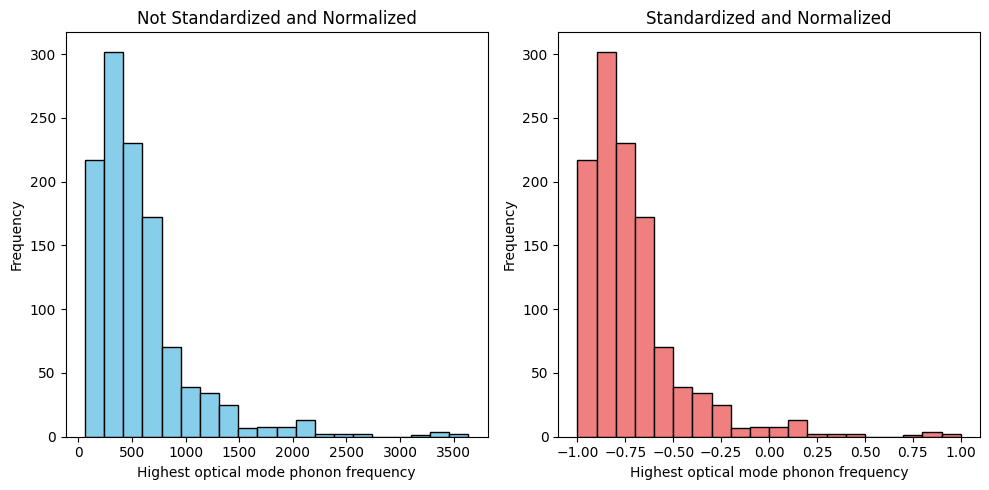

In [ ]:
import matplotlib.pyplot as plt
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns of subplots.

# Plot the first histogram
axes[0].hist(df_train['target'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Not Standardized and Normalized')
axes[0].set_xlabel('Highest optical mode phonon frequency')
axes[0].set_ylabel('Frequency')

# Plot the second histogram
axes[1].hist(norm_train, bins=20, color='lightcoral', edgecolor='black')
axes[1].set_title('Standardized and Normalized')
axes[1].set_xlabel('Highest optical mode phonon frequency')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_train['target'] = norm_train
df_test['target'] = norm_test
test = df_test.to_dict(orient = 'records')
train = df_train.to_dict(orient = 'records')

## Create dataset for training
We select 200 random datapoints for illustration

In [ ]:
import random
def Rand(start, end, num):
  random.seed(123)
  random_ids =  random.sample(range(start, end),num)
  return random_ids
random_pts = Rand(0, 1137, 200)
print(Rand(0, 1137, 200))

train_200 = []
for i in sorted(random_pts, reverse=True):
    train_200.append(train[i])

print(f'No of randomly selected datapoints',len(train_200))

[107, 548, 178, 834, 545, 220, 78, 776, 1098, 680, 697, 106, 326, 276, 690, 683, 502, 335, 3, 893, 179, 773, 143, 13, 646, 918, 208, 89, 189, 291, 258, 43, 597, 881, 976, 543, 961, 75, 624, 703, 1068, 989, 423, 1079, 645, 25, 815, 1050, 889, 1102, 995, 1066, 859, 767, 1044, 65, 371, 169, 997, 536, 348, 685, 1135, 801, 150, 935, 793, 688, 33, 387, 180, 744, 26, 720, 469, 830, 1089, 1026, 122, 589, 1013, 477, 1114, 990, 363, 314, 910, 775, 944, 90, 20, 275, 934, 395, 525, 556, 860, 0, 222, 128, 1045, 727, 181, 887, 17, 1097, 1119, 827, 59, 660, 537, 967, 67, 848, 713, 48, 858, 131, 294, 762, 481, 160, 117, 1062, 1100, 627, 299, 596, 797, 754, 259, 1095, 691, 1059, 244, 341, 791, 885, 127, 278, 931, 42, 715, 921, 923, 622, 878, 57, 324, 665, 1058, 1054, 281, 1024, 214, 1117, 755, 460, 696, 190, 1036, 498, 416, 659, 541, 88, 1025, 164, 403, 1034, 408, 35, 397, 549, 472, 174, 649, 171, 698, 1101, 273, 1094, 277, 991, 1008, 526, 810, 459, 12, 1012, 250, 738, 943, 741, 861, 734, 443, 919, 702

In [ ]:
from jarvis.core.atoms import Atoms
import os
output_dir = "./phonons/data"
os.makedirs(output_dir, exist_ok=True) # create data dir if does not exist
output_file_name="id_prop.csv"
with open(output_file_name, 'w') as f:
    for i in train_200:
        atoms = Atoms.from_dict(i["atoms"])
        jid = i["jid"]
        poscar_name = os.path.join(output_dir, "POSCAR-" + str(jid) + ".vasp") # path to poscar
        target = i['target']
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))

# Create a configuration file

Save a configuration file contains all parameters required for defining the model architecture and training process. We will use the alignn_atomwise model for making graph level prediction. Note that alignn_atomwise can make both graph and atom level predictions.

 Key parameters are described below:

 ``random_seed:`` Establishes a seed for random number generation to ensure reproducibility.
   
   ``classification_threshold:``  If classifying, sets a decision boundary to classify between classes; is null, indicating regression.

   `n_val: `                 Explicitly defines the number of data points to be used for validation, and is null, meaning using a ratio instead.
   
   `n_test: `                Explicitly defines the number of data points to be used for testing, and is null, meaning using a ratio instead.
   
   `n_train:`                Explicitly defines the number of data points to be used for training, and is null, meaning using a ratio instead.
   
   `train_ratio: `          Specifies the proportion of the dataset to be used for training the model.
   
   `val_ratio:`             Specifies the proportion of the dataset to be used for validation.
   
   `test_ratio:`          Specifies the proportion of the dataset to be used for testing the model.

   `epochs:`                 Defines the number of complete passes through the training dataset.

   `batch_size:`             Specifies the number of samples to process in one iteration during training.

   `weight_decay:`          Applies regularization to prevent overfitting by penalizing large weights.

   `learning_rate:`         Controls how much the model weights are adjusted during training.

   `model.name:`            Specifies the name of the model architecture, in this case 'alignn_atomwise'.

   `model.alignn_layers:`    Defines the number of ALIGNN layers in the model.
   
   `model.gcn_layers:`       Defines the number of GCN layers in the model.
   
   `model.atom_input_features:`   Specifies the number of features representing each atom before processing.
   
   `model.edge_input_features:`   Specifies the number of features representing each edge before processing.
   
   `model.triplet_input_features:` Specifies the number of features representing triplets of atoms before processing.
   
   `model.embedding_features:`  Specifies the dimension of the embedding layer used in the model.
   
   `model.hidden_features:`   Specifies the number of hidden units in the neural network layers.
   
   `model.output_features:`   Specifies the dimension of the final output of the model.



In [ ]:
import json
config = {
    "version": "112bbedebdaecf59fb18e11c929080fb2f358246",
    "dataset": "user_data",
    "target": "target",
    "atom_features": "cgcnn",
    "neighbor_strategy": "k-nearest",
    "id_tag": "jid",
    "dtype": "float32",
    "random_seed": 123,
    "classification_threshold": None,
    "n_val": None,
    "n_test": None,
    "n_train": None,
    "train_ratio": 0.8,
    "val_ratio": 0.2,
    "test_ratio": 0,
    "target_multiplication_factor": None,
    "epochs": 10,
    "batch_size": 2,
    "weight_decay": 1e-05,
    "learning_rate": 0.001,
    "filename": "A",
    "warmup_steps": 2000,
    "criterion": "mse",
    "optimizer": "adamw",
    "scheduler": "onecycle",
    "pin_memory": False,
    "save_dataloader": False,
    "write_checkpoint": True,
    "write_predictions": True,
    "store_outputs": True,
    "progress": True,
    "log_tensorboard": False,
    "standard_scalar_and_pca": False,
    "use_canonize": True,
    "num_workers": 0,
    "cutoff": 8.0,
    "cutoff_extra": 3.0,
    "max_neighbors": 12,
    "keep_data_order": True,
    "normalize_graph_level_loss": False,
    "distributed": False,
    "data_parallel": False,
    "n_early_stopping": None,
    "output_dir": "temp",
    "use_lmdb": True,
    "model": {
        "name": "alignn_atomwise",
        "alignn_layers": 4,
        "gcn_layers": 4,
        "atom_input_features": 92,
        "edge_input_features": 80,
        "triplet_input_features": 40,
        "embedding_features": 64,
        "hidden_features": 64,
        "output_features": 1,
        "grad_multiplier": -1,
        "calculate_gradient": False,
        "atomwise_output_features": 0,
        "graphwise_weight": 1.0,
        "gradwise_weight": 1.0,
        "stresswise_weight": 0.0,
        "atomwise_weight": 0.0,
        "link": "identity",
        "zero_inflated": False,
        "classification": False,
        "force_mult_natoms": False,
        "energy_mult_natoms": False,
        "include_pos_deriv": False,
        "use_cutoff_function": False,
        "inner_cutoff": 3.0,
        "stress_multiplier": 1.0,
        "add_reverse_forces": True,
        "lg_on_fly": True,
        "batch_stress": True,
        "multiply_cutoff": False,
        "use_penalty": True,
        "extra_features": 0,
        "exponent": 5,
        "penalty_factor": 0.1,
        "penalty_threshold": 1.0
    }
}

file_path = "config.json"

with open(file_path, "w") as json_file:
    json.dump(config, json_file)
with open("/content/form_energy/config.json", "w") as json_file:
    json.dump(config, json_file)

# Train a model from scratch

We now construct a model from scratch for predicting the highest optical phonon mode frequncy of the materials.
The config.json file contains all the required parameters for load and training the alignn_atomwise model.

Training the SCRATCH model

In [ ]:
%%time
!train_alignn.py --root_dir "./" --config "config.json" --output_dir=phonons --epochs 10

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
fatal: not a git repository (or any of the parent directories): .git
world_size 0
root_dir ./
id_prop_csv_file exists True
len dataset 200
train_stress False
Using LMDB dataset.
MAX val: 0.400152
MIN val: -0.998882
MAD: 0.17105815215
Data error Found arra

# Fine-tune a model using a model pre-trained on formation energy dataset

Now we load a pre-trained model on formation energy and then fine-tune it on the phonons dataset.
We will compare the predictions made by the fine-tuned model and the model constructed from scratch for the higest optical phonon mode predictions.

Loading a pre-trained model on formation energy and fine-tuning on the phonon dataset. Note the pre-trained model checkpoint was obtained by training on 1000 formation energy datapoints for 500 epochs. The above code for constructing the scratch model with the respective data and `--epochs 500` can be used to generate the checkpoint.

In [ ]:
%%time
!train_alignn.py --root_dir "./" --config "config.json" --output_dir=fine-tune --restart_model_path='/content/form_energy/current_model.pt' --epochs 10

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
fatal: not a git repository (or any of the parent directories): .git
world_size 0
root_dir ./
id_prop_csv_file exists True
len dataset 200
train_stress False
Restarting the model training: /content/form_energy/current_model.pt
Rest config name='alignn_atomwise' alignn_layers=4 gcn_layers=4 atom_input_features=92 edge_input_features=80 triplet_input_features=40 embedding_features=64 hidden_features=64 output_features=1 grad_multiplier=-1 calculate_gradient=False atomwise_output_features=0 graphwise_weight=1.0 gradwi

# Test the scratch and fine-tuned model

We will now test both the scratch and the fine-tuned model on the prediction accuracy

In [ ]:
import sys
from alignn.models.alignn_atomwise import ALIGNNAtomWise, ALIGNNAtomWiseConfig
import torch
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
import pandas as pd
import numpy as np

filename_scratch = 'phonons/current_model.pt'
filename_ft = 'fine-tune/current_model.pt'
device = "cpu"

# Initialize two separate models
model_scratch = ALIGNNAtomWise(ALIGNNAtomWiseConfig(name ='alignn_atomwise',gcn_layers = 4, atom_input_features = 92, alignn_layers = 4, output_features = 1 ))
model_ft = ALIGNNAtomWise(ALIGNNAtomWiseConfig(name ='alignn_atomwise',gcn_layers = 4, atom_input_features = 92, alignn_layers = 4, output_features = 1 ))

# Load state dicts seperately
state_dict_scratch = torch.load(filename_scratch, map_location=device)
state_dict_ft = torch.load(filename_ft, map_location=device)

# Load the model parameters
model_scratch.load_state_dict(state_dict_scratch)
model_ft.load_state_dict(state_dict_ft)

model_scratch.eval()
model_ft.eval()
cutoff = 8.0
model_scratch = model_scratch.to(device)
model_ft = model_ft.to(device)
max_neighbors = 12

# Save the current standard output (e.g., the console) to a variable
original_stdout = sys.stdout
results_scratch = []
results_ft = []
for i in test:
    atoms = Atoms.from_dict(i["atoms"])
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors)
    out_data_scratch = (model_scratch([g.to(device), lg.to(device),[atoms.lattice.a,atoms.lattice.b,atoms.lattice.c]])['out']
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist())
    results_scratch.append({ "jid": i['jid'],
            "out_data": out_data_scratch[0],
            "target": i['target']
        })
    print("jid", i['jid'],
            "out_data", out_data_scratch[0],
            "target", i['target'])
    out_data_ft = (model_ft([g.to(device), lg.to(device),[atoms.lattice.a,atoms.lattice.b,atoms.lattice.c]])['out']
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist())
    results_ft.append({ "jid": i['jid'],
            "out_data": out_data_ft[0],
            "target": i['target']
        })
    print("jid", i['jid'],
            "out_data", out_data_ft[0],
            "target", i['target'])
csv_scratch = pd.DataFrame(results_scratch)
csv_ft = pd.DataFrame(results_ft)

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


jid 1250 out_data -0.7176106572151184 target [-0.65567356]
jid 1250 out_data -0.5940433144569397 target [-0.65567356]
jid 1248 out_data -0.7022044658660889 target [-0.68529905]
jid 1248 out_data -0.5239205360412598 target [-0.68529905]
jid 1244 out_data -0.6555631756782532 target [-0.66797093]
jid 1244 out_data -0.594676673412323 target [-0.66797093]
jid 1242 out_data -1.0048166513442993 target [-0.88708776]
jid 1242 out_data -0.8426024913787842 target [-0.88708776]
jid 1238 out_data -0.49109792709350586 target [-0.00447177]
jid 1238 out_data -0.4467701017856598 target [-0.00447177]
jid 1230 out_data -0.8997505903244019 target [-0.87870319]
jid 1230 out_data -0.8484123349189758 target [-0.87870319]
jid 1211 out_data -1.0311400890350342 target [-0.92062605]
jid 1211 out_data -0.7992666959762573 target [-0.92062605]
jid 1208 out_data -0.7137799263000488 target [-0.67859139]
jid 1208 out_data -0.6586570143699646 target [-0.67859139]
jid 1205 out_data -0.48045265674591064 target [-0.196757

## Undo the standardization and normalization operation

Remember to undo the normalization and standardization operations in the same order as mentioned before analyzing the results. The follwing formulas are used in the same order to undo the operations.

**Unnormalized_value =  $\frac{(\textbf{Normalized value} + 1)}{2}$  $\times$ (Original_scaled_max - Original_scaled_min) + Original_scaled_min**

**Original_value = (Unnormalized_value $\times$ Original_std_dev) + Original_mean**

```
      Original_std_dev => standard deviation of unscaled and unnormalized training dataset
      Original_mean => mean of unscaled and unnormalized training dataset
      Original_scaled_max =>  maxima of the scaled training dataset
      Original_scaled_min =>  minima of the scaled training dataset
```


In [ ]:
from sklearn.preprocessing import StandardScaler
import statistics as s
scaler = StandardScaler()
with open('/content/phonons/TRAIN-UNSTD.json', 'r') as f:
    train_data = json.load(f)
df_train = pd.DataFrame.from_dict(train_data)

#Get min and max from this array
arr1 = scaler.fit_transform(df_train[['target']]).flatten()
#Get range from standardized data
original_min = min(arr1)
original_max = max(arr1)


#Get the mean and std_dev from this array
raw_target = np.array(df_train['target'])
# Standardized data mean, stdev and range
original_mean = s.mean(raw_target)
original_std = s.stdev(raw_target)


def undo_normalization_and_standardization(normalized_array, original_mean, original_std, original_min, original_max):
    # Step 1: Undo the normalization
    unnormalized_array = (normalized_array + 1) / 2 * (original_max - original_min) + original_min

    # Step 2: Undo the standardization
    original_array = unnormalized_array * original_std + original_mean

    return original_array

FileNotFoundError: [Errno 2] No such file or directory: '/content/phonons/TRAIN-UNSTD.json'

## Analyze the performance metrics

In [ ]:
import pandas
from sklearn.metrics import r2_score, mean_absolute_error
###################Print results of the scratch model##################
pred = undo_normalization_and_standardization(np.array(csv_scratch["out_data"]), original_mean, original_std, original_min, original_max)
target = undo_normalization_and_standardization(np.array(csv_scratch["target"]), original_mean, original_std, original_min, original_max)
r2= r2_score(target, pred)
mae = mean_absolute_error(target, pred)
print('Scratch model R2 score',r2)
print('Scratch model MAE score',mae)
print('############################################')
##################Print results of the fine-tuned model################
pred = undo_normalization_and_standardization(np.array(csv_ft["out_data"]), original_mean, original_std, original_min, original_max)
target = undo_normalization_and_standardization(np.array(csv_ft["target"]), original_mean, original_std, original_min, original_max)
r2= r2_score(target, pred)
mae = mean_absolute_error(target, pred)
print('Fine-tuned model R2 score',r2)
print('Fine-tuned model MAE score',mae)


Scratch model R2 score 0.49318306976955495
Scratch model MAE score 231.0842744984917
############################################
Fine-tuned model R2 score 0.6514972649227397
Fine-tuned model MAE score 212.85688423034946


# Using other pre-trained models from ALIGNN

We'll now utilize another pre-trained model from the repository. The following code utilizes a model trained on JARVIS-DFT formation energy.

Alter the snippet of code below to compare the formation energies of the structures generated from crystalLLM and Chemeleon
Refer to the [documentation](https://github.com/usnistgov/alignn) for other pre-trained models

In [ ]:
atoms = Atoms.from_cif('/content/Si.cif')# Load the pickle/cif files that you generated in the previous exercise
atoms.write_poscar('POSCAR_trial')

list index out of range


In [ ]:
!pretrained.py --model_name jv_formation_energy_peratom_alignn  --file_format poscar --file_path POSCAR_trial

/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
100% 47.5M/47.5M [00:03<00:00, 14.4MiB/s]
Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /usr/local/bin/jv_formation_energy_peratom_alignn.zip
Config /content/jv_formation_energy_peratom_alignn/config.json
Predicted value: jv_formation_energy_peratom_alignn POSCAR_trial [0.0037604793906211853]
